Upregulated genes: 264
Downregulated genes: 322


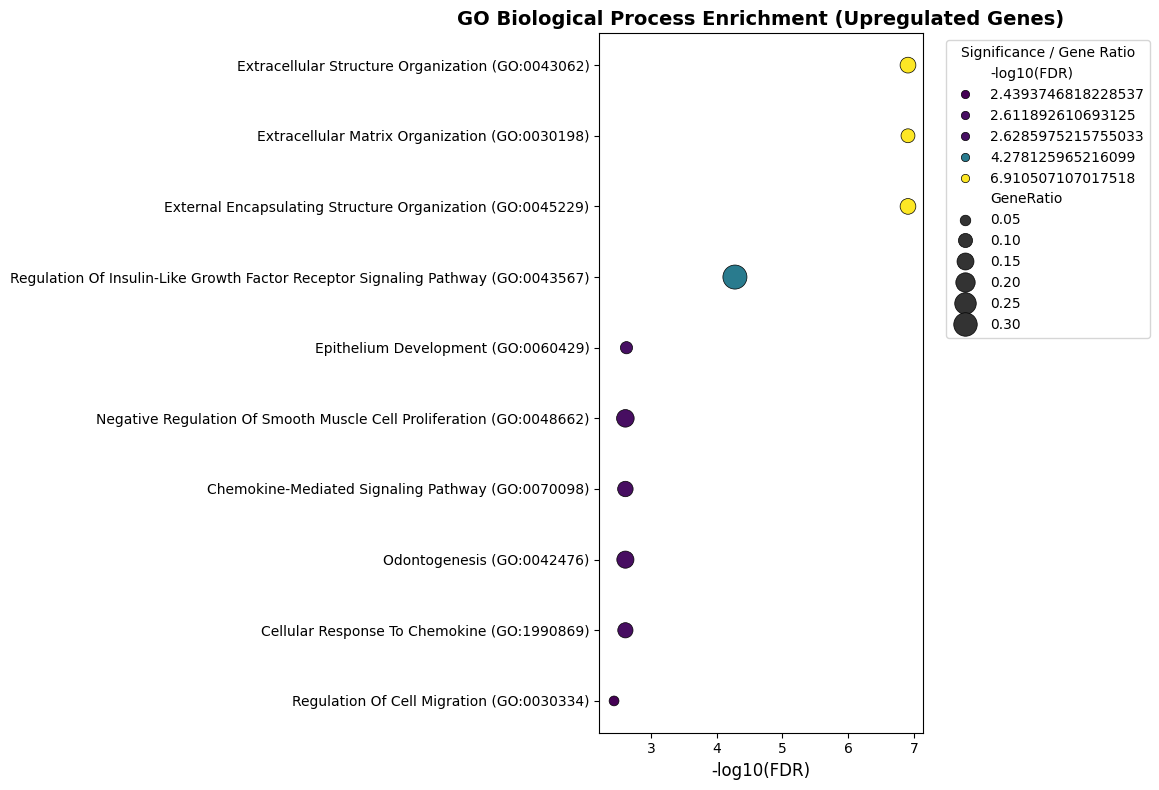

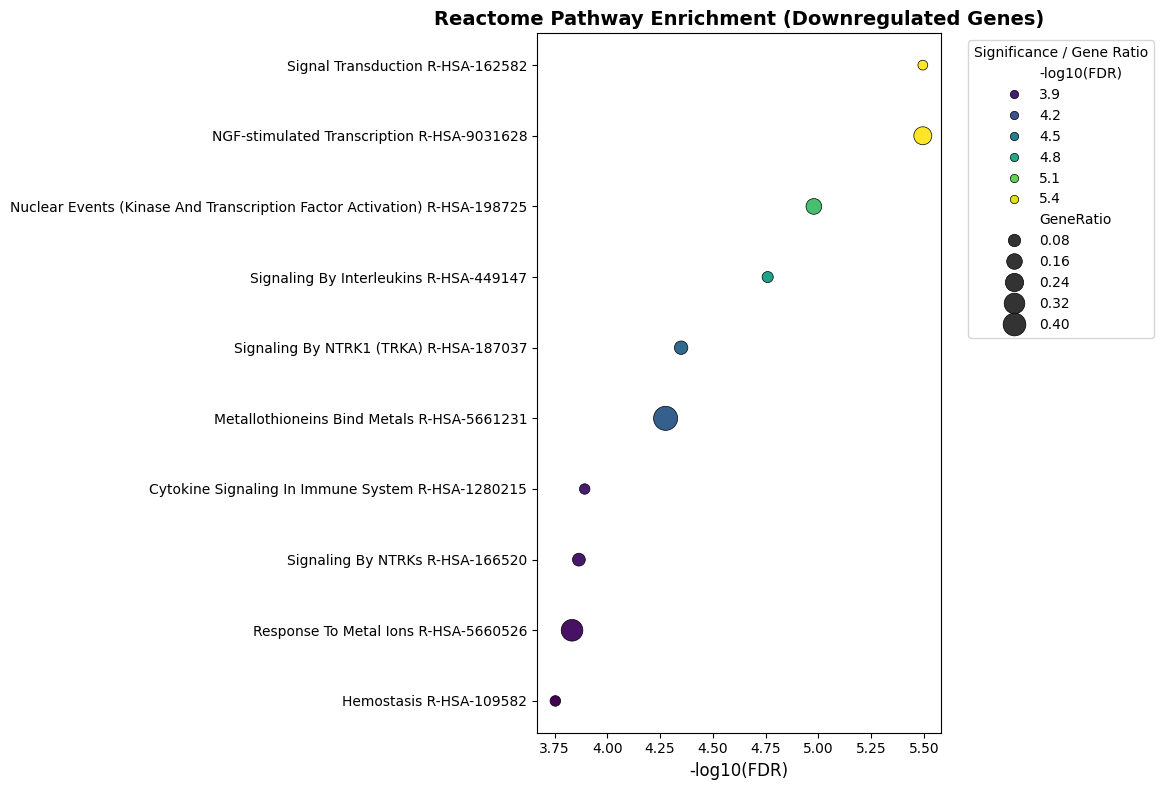

In [1]:
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load DEG Table
df = pd.read_excel("DEG_data.xlsx", header=2)

# Split into Up & Down DEGs
UP = df[(df["adj.P.Val"] < 0.05) & (df["logFC"] >= 0.263)]["Gene"].tolist()
DOWN = df[(df["adj.P.Val"] < 0.05) & (df["logFC"] <= -0.263)]["Gene"].tolist()

print("Upregulated genes:", len(UP))
print("Downregulated genes:", len(DOWN))

# Save gene lists
pd.Series(UP).to_csv("up_genes.txt", index=False, header=False)
pd.Series(DOWN).to_csv("down_genes.txt", index=False, header=False)

# GO Biological Process Enrichment (UP)
enrich_up = gp.enrichr(
    gene_list=UP,
    gene_sets="GO_Biological_Process_2023",
    organism="Human",
    outdir=None
)

# Keep top 10 terms
up_results = enrich_up.results.head(10)

# Reactome Pathway Enrichment (DOWN)
enrich_down = gp.enrichr(
    gene_list=DOWN,
    gene_sets="Reactome_2022",
    organism="Human",
    outdir=None
)

# Keep top 10 terms
down_results = enrich_down.results.head(10)

# Make dotplot
def make_dotplot(df, title, outfile=None):
    df = df.sort_values("Adjusted P-value").head(10)
    df["-log10(FDR)"] = -np.log10(df["Adjusted P-value"])

    if "Overlap" in df.columns:
        df["GeneRatio"] = df["Overlap"].str.split("/").apply(lambda x: int(x[0]) / int(x[1]))
    else:
        df["GeneRatio"] = 0.1

    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df,
        x="-log10(FDR)",
        y="Term",
        hue="-log10(FDR)",
        size="GeneRatio",
        palette="viridis",
        sizes=(50, 300),
        edgecolor="black",
        linewidth=0.5
    )

    plt.title(title, fontsize=14, weight="bold")
    plt.xlabel("-log10(FDR)", fontsize=12)
    plt.ylabel("")
    plt.legend(title="Significance / Gene Ratio", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Save plot
    if outfile:
        plt.savefig(outfile, dpi=300, bbox_inches="tight")

    plt.tight_layout()
    plt.show()

# Plot UP enrichment
make_dotplot(up_results,
             "GO Biological Process Enrichment (Upregulated Genes)",
             outfile="UP_enrichment_dotplot.png")

# Plot DOWN enrichment
make_dotplot(down_results,
             "Reactome Pathway Enrichment (Downregulated Genes)",
             outfile="DOWN_enrichment_dotplot.png")
